In [1]:
import random
import time

import numpy as np 
import torch
from scipy import integrate
import pandas as pd
import pickle as pkl

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation



In [2]:
class Ergodic_Dynamics_Iterator:
    def __init__(self):
        pass

    def __str__(self):
        pass

    def apply_dynamics(self):
        pass

    def __iter__(self):
        return self

    def __next__(self):
        pass



In [3]:
def runge_katta_4(self, f, tn, yn, h):
    k1 = f(tn, yn)
    k2 = f(tn + h/2, yn + h * (k1/2))
    k3 = f(tn + h/2, yn + h * (k2/2))
    k4 = f(tn + h  , yn + h * k3)
    return tn + h, yn + (1/6) * h * (k1 + 2*k2 + 2*k3 + k4)

def get_h_k(new_k, U_shape):
    U_bounds = [[0, U_bound] for U_bound in U_shape]
    integrand = lambda *x : np.prod(np.cos(np.array(x)*new_k)**2)
    integral_result, _ = integrate.nquad(integrand, U_bounds)
    return np.sqrt(integral_result)

def get_fourier_fn_k(new_k, U_shape):
    # only torch one because we need gradient
    h_k = torch.tensor(get_h_k(new_k, U_shape))
    return lambda x : (1/h_k) * torch.prod(torch.cos(x*torch.tensor(new_k)))

def get_lambda_k(new_k, n):
    s = (n+1)/2
    lambda_k = 1 / (1 + np.linalg.norm(new_k)**2)**s
    return lambda_k

def get_mu_k(mu, f_k, U_shape):
    U_bounds = [[0, U_bound] for U_bound in U_shape]
    # is mu defined everywhere in the bounds
    integrand = lambda *x: mu(np.array(x)) * f_k(torch.tensor(x)).numpy()
    integral_result, _ = integrate.nquad(integrand, U_bounds)
    return integral_result
    
def get_functions_k(k, mu, U_shape):
    n = len(U_shape)
    new_k = np.array(k)*np.pi/np.array(U_shape)
    fourier_k = get_fourier_fn_k(new_k, U_shape)
    grad_fourier_k = lambda t: torch.autograd.functional.jacobian(fourier_k, t)  
    lambda_k = get_lambda_k(new_k, n)
    mu_k = get_mu_k(mu, fourier_k, U_shape)
    return {'fourier_k': fourier_k, 
            'grad_fourier_k': grad_fourier_k, 
            'mu_k': mu_k, 
            'C_k': 0,
            'lambda_k': lambda_k}

def get_functions(U_shape, mu, K):
    n = len(U_shape)
    return {k: get_functions_k(k, mu, U_shape) for k in np.ndindex(*[K]*n)}





In [4]:
class First_Order_Ergodic_Dynamics_Iterator_MM(Ergodic_Dynamics_Iterator):
    """
    Matthew Mezic

    Input
        N (int): number of agents
        K (int): related to number of desired fourier functions, number is K^n for n = dim U
        u_max (float): max speed for feedback law
        U_shape (num --int? tuple): n-tuple describing shape of rectangular domain U
            e.g. U = [0, L1]x[0, L2] --> U_shape = (L1, L2)
        prob_distribution
    """
    def __init__(self, init_positions, U_shape=(1, 1), prob_distribution=(lambda x: 1.0), 
                    N=1, time_step=0.01, K=10, u_max=0.1, eps=1e-5):
        self.U_shape = U_shape
        self.mu = prob_distribution
        self.N = N
        self.K = K
        self.u_max = u_max
        self.eps = eps
        
        self.time_log = [0]
        # position_log[t][j] corresponds to jth agent at time t
        self.position_log = [init_positions]
        self.time_step = time_step

        self.functions = get_functions(self.U_shape, self.mu, self.K)
        self.phi2_log = []

    def __str__(self):
        info = "Matthew and Mezic Ergodic Iterator"
        bounds = "x".join([str((0, ub)) for ub in self.U_shape])
        return f"{info}\n\tU: {bounds}\n\tN: {self.N}\n\tK: {self.K}\n\tu_max: {self.u_max}"

    def apply_dynamics(self):
        N = self.N
        K = self.K
        n = len(self.U_shape)
        x = self.position_log
        t = self.time_log[-1]
        delta_t = self.time_step

        new_x = []
        phi2 = 0  

        S = dict()
        for k in np.ndindex(*[K]*n):
            """
            need to calculate all the S_k (basically calculating the C_k)
            """
            f_k = self.functions[k]['fourier_k']
            mu_k = self.functions[k]['mu_k']
            lambda_k = self.functions[k]['lambda_k']
            grad_f_k = self.functions[k]['grad_fourier_k']

            """
            to calculate C_k, need information on every agent's location
            """
            if len(self.time_log) <= 1:
                s_k = (1/N) * sum([f_k(torch.tensor(x[-1][i])) for i in range(N)]) - mu_k
                S_k = 0
                
            else:
                # trapezoid rule to approximate taking integral
                incr_C_k = 0
                for i in range(N):
                    prev_f_k = f_k(torch.tensor(x[-2][i])).numpy() 
                    curr_f_k = f_k(torch.tensor(x[-1][i])).numpy() 
                    incr_C_k += (1/2) * (prev_f_k + curr_f_k) * delta_t 
                self.functions[k]['C_k'] += incr_C_k
                S_k = self.functions[k]['C_k'] - N*t*mu_k
                s_k = S_k/(N*t)
            phi2 += lambda_k * (s_k**2)
            S[k] = S_k

        self.phi2_log.append(phi2)

        
        
        for j in range(N):
            B_j = np.zeros(n)

            # print("x position for agent ", j, ": ", x[-1][j], x[-1][j].shape)

            for k in np.ndindex(*[K]*n):
                lambda_k = self.functions[k]['lambda_k']
                grad_f_k = self.functions[k]['grad_fourier_k']
                # print("lambda", k, ": ", lambda_k)
                # print("S ", k, ": ", S[k])
                # print("fourier_", k, ": ", self.functions[k]['fourier_k'](torch.tensor(x[-1][j])))
                # print("grad_f_", k, ": ", grad_f_k(torch.tensor(x[-1][j])).detach().numpy())
                B_j += lambda_k * S[k] * grad_f_k(torch.tensor(x[-1][j])).detach().numpy()
                # print("B for agent ", j, "k ", k, ": ", B_j)  
 


            # B_j = 0 or agent is too near boundary (because we are using approximations, 
            #   may end up slipping outside) 
            # # or every so often do some random movement
            if (np.linalg.norm(B_j) == 0 
                or (x[-1][j] < self.eps).any() or (np.array(self.U_shape) - x[-1][j] < self.eps).any()):
                # or random.randrange(10) < 1:
                print("oh no at time ", t)
                
                U_center = np.array(self.U_shape)/2
                if (U_center == x[-1][j]).all():
                    # move in random direction away from center 
                    n = len(self.U_shape)
                    assert(x[-1][j].size == n)
                    B_j = np.zeros(n)
                    r_idx = 0
                    # r_idx = random.randrange(n)
                    B_j[r_idx] = 1
                    
                else:
                    # aim towards center if not already at center
                    B_j = -1 * (U_center - x[-1][j])
            
            u_j = -1 * self.u_max * B_j / np.linalg.norm(B_j)

            # Euler method
            new_x_j = x[-1][j] + u_j*delta_t
            new_x.append(new_x_j)

        self.time_log.append(t + delta_t)
        self.position_log.append(new_x)

    def __iter__(self):
        return self

    def __next__(self):
        self.apply_dynamics()
        # phi2 is for the previous time's
        return self.time_log[-1], self.position_log[-1], self.phi2_log[-1]

In [5]:
class First_Order_Ergodic_Dynamics_Iterator_Optimizer(Ergodic_Dynamics_Iterator):
    def __init__(self, init_positions, U_shape=(1, 1), prob_distribution=(lambda x: 1.0), 
                    N=1, time_step=0.01, K=10, u_max=0.1, eps=1e-5):
        self.U_shape = U_shape
        self.mu = prob_distribution
        self.N = N
        self.K = K
        self.u_max = u_max
        self.eps = eps
        
        self.time_log = [0]
        # position_log[t][j] corresponds to jth agent at time t
        self.position_log = [init_positions]
        self.time_step = time_step

        self.functions = get_functions(self.U_shape, self.mu, self.K)
        self.phi2_log = []

        # parameters are going to be direction that agents are moving
        self.optimizer = optim.Adam(model.parameters(), weight_decay=5e-6, lr=1e-2)
        self.losses = [lambda x: x for i in range(self.N)]

    def __str__(self):
        info = "Optimization-Based Ergodic Iterator"
        bounds = "x".join([str((0, ub)) for ub in self.U_shape])
        return f"{info}\n\tU: {bounds}\n\tN: {self.N}\n\tK: {self.K}\n\tu_max: {self.u_max}"

    def apply_dynamics(self):
        self.optimizer.zero_grad()
        for i in range(self.N):
            
            loss = self.losses[i](thing)
            loss.backward()
        optimizer.step()

    """
    optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        return loss
    optimizer.step(closure)
    """
    
    def __iter__(self):
        return self

    def __next__(self):
        self.apply_dynamics()
        # phi2 is for the previous time's
        return self.time_log[-1], self.position_log[-1], self.phi2_log[-1]
class Ergodic_Dynamics_Iterator_Hetero(Ergodic_Dynamics_Iterator):
    pass
class Ergodic_Dynamics_Iterator_Distributed(Ergodic_Dynamics_Iterator):
    pass

p1_total:  0.18140542135542154
p2_total:  0.1863622475404353


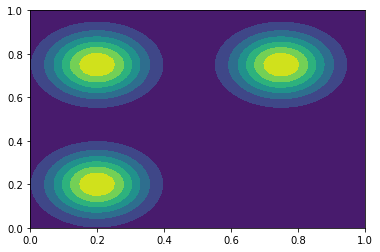

In [6]:
# Probability Distribution
def unnorm_p1(x): 
    return np.exp(-50.5 * np.sum((x[:2] - 0.2)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - 0.75)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - np.array([0.2, 0.75]))**2))
p1_total, _ = integrate.nquad(lambda *x: unnorm_p1(np.array(x)), [[0, 1], [0, 1]])
print("p1_total: ", p1_total)
p1 = lambda x: unnorm_p1(x)/p1_total

def unnorm_p2(x): 
    return np.exp(-50.5 * np.sum((x[:2] - 0.3)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - 0.65)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - np.array([0.3, 0.55]))**2))
p2_total, _ = integrate.nquad(lambda *x: unnorm_p2(np.array(x)), [[0, 1], [0, 1]])
print("p2_total: ", p2_total)
p2 = lambda x: unnorm_p2(x)/p2_total

# Grid and Display
X,Y = np.meshgrid(*[np.linspace(0,1)]*2)
_s = np.stack([X.ravel(), Y.ravel()]).T


plt.contourf(X, Y, np.array(list(map(p1, _s))).reshape(X.shape))      




In [21]:
x_init = [np.array([0.54,0.3]), np.array([0.2, 0.7]), np.array([0.8, 0.1])]

start_time = time.time()
#  iterator
mm_ergodic = First_Order_Ergodic_Dynamics_Iterator_MM(x_init, U_shape=(1, 1), 
                    prob_distribution=p1, N=3, time_step=0.1, K=3, u_max=1)
                    # u_max = 0.1
                    # K = 10
end_time = time.time()
print("mm_ergodic init: ", end_time - start_time, "s")

# Plot the log on top of the probability distribution (animate?)


mm_ergodic init:  19.0685715675354 s


In [22]:
for i in range(100):
    start_time = time.time()
    t, x, phi2 = next(mm_ergodic)    
    
    end_time = time.time()   


oh no at time  0
oh no at time  0
oh no at time  0
oh no at time  1.3
oh no at time  1.4000000000000001
oh no at time  1.6000000000000003
oh no at time  1.8000000000000005
oh no at time  2.0000000000000004
oh no at time  2.700000000000001
oh no at time  2.9000000000000012
oh no at time  3.700000000000002
oh no at time  3.800000000000002
oh no at time  3.900000000000002
oh no at time  3.900000000000002
oh no at time  4.100000000000001
oh no at time  4.300000000000001
oh no at time  4.5
oh no at time  6.999999999999991
oh no at time  7.19999999999999
oh no at time  7.19999999999999
oh no at time  8.299999999999986
oh no at time  8.999999999999984
oh no at time  9.699999999999982


In [9]:
print(len([mm_ergodic.position_log[m] for m in range(100)]))

100


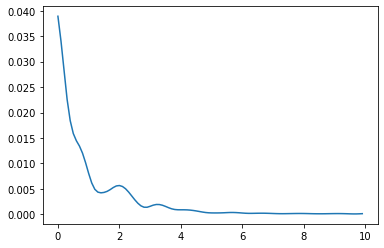

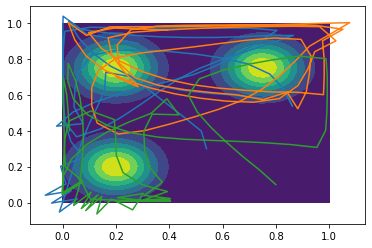

In [23]:
# Plot Ergodicity
plt.plot(mm_ergodic.time_log[:-1], mm_ergodic.phi2_log)
plt.show()

# Plot trajectory
X,Y = np.meshgrid(*[np.linspace(0,1)]*2)
_s = np.stack([X.ravel(), Y.ravel()]).T
ub = len(mm_ergodic.position_log)

plt.contourf(X, Y, np.array(list(map(p1, _s))).reshape(X.shape))
for i in range(mm_ergodic.N):  
    plt.plot([mm_ergodic.position_log[m][i][0] for m in range(ub)], [mm_ergodic.position_log[m][i][1] for m in range(ub)])
plt.show()

In [11]:
print(len(mm_ergodic.position_log))
print(mm_ergodic.position_log[-1])

101
[array([0.28422186, 0.88591815]), array([0.39331819, 0.96072087]), array([0.02592358, 0.39967027])]


NameError: name 'log_X' is not defined

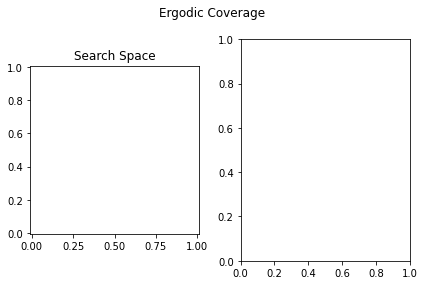

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Ergodic Coverage')
fig.tight_layout()

ax1.set_title('Search Space')
ax1.set_aspect('equal')
space = 1e-2
ax1.set_xlim(0-space, 1+space)
ax1.set_ylim(0-space, 1+space)
X,Y = np.meshgrid(*[np.linspace(0,1)]*2)
_s = np.stack([X.ravel(), Y.ravel()]).T
ub = len(log_X)
ax1.contourf(X, Y, np.array(list(map(p1, _s))).reshape(X.shape))  
ax1.scatter(log_X[:ub], log_Y[:ub], s=0.1, c='m')

ax2.set_title('Ergodicity')
ax2.set(xlabel='Time')

ax2.plot(mm_ergodic.time_log[:-1], mm_ergodic.phi2_log)
plt.show()

In [ ]:
def animate2d_ergodic(ergodic_iter, num_iter=None, filename=None):
    """
    ‘b’	blue
    ‘g’	green
    ‘r’	red
    ‘c’	cyan
    ‘m’	magenta
    ‘y’	yellow
    ‘k’	black
    ‘w’	white
    """
    if len(ergodic_iter.U_shape) != 2:
        raise NotYetImplemented("Dimension: ", len(ergodic_iter.U_shape), 
                                "- Animation of this dimension is not supported.")

    colors = ['r', 'm', 'c', 'y', 'g', 'b', 'k', 'w']
    if ergodic_iter.N > len(colors):
        raise NotYetImplemented("Number of agents: ", ergodic_iter.N, 
                                "- Animation of this dimension is not supported.")

    fig, (ax1, ax2) = plt.subplots(1, 2)

    fig.suptitle('Ergodic Coverage')
    fig.tight_layout()


    ax1.set_title('Search Space')
    ax1.set_aspect('equal')
    ax1.set_xlim(0, ergodic_iter.U_shape[0])
    ax1.set_ylim(0, ergodic_iter.U_shape[1])

    X,Y = np.meshgrid(np.linspace(0, ergodic_iter.U_shape[0]), np.linspace(0, ergodic_iter.U_shape[1]))
    _s = np.stack([X.ravel(), Y.ravel()]).T
    ax1.contourf(X, Y, np.array(list(map(ergodic_iter.mu, _s))).reshape(X.shape))


    ax2.set_title('Ergodicity')
    ax2.set(xlabel='Time')

    pos_data = [([], []) for i in range(ergodic_iter.N)]
    time_data = []
    ergodicity_data = []
    pos_lns = []
    for i in range(ergodic_iter.N):
        pos_ln, = ax1.plot(pos_data[i][0], pos_data[i][1], c=colors[i], label=i)
        pos_lns.append(pos_ln)
    ergodicity_ln, = ax2.plot(time_data, ergodicity_data, c='b')

    def animate2d_init():
        phi2_max = 0.1 if num_iter is not None else max(ergodic_iter.phi2_log)
        time_max = num_iter if num_iter is not None else min(1000, len(ergodic_iter.phi2_log))
        ax2.set_xlim(0, time_max)
        ax2.set_ylim(0, phi2_max)
        return (ergodicity_ln, *pos_lns)


    def animate2d_from_logs_update(frame):
        for i in range(ergodic_iter.N):
            pos_data[i][0].append(ergodic_iter.position_log[frame][i][0])
            pos_data[i][1].append(ergodic_iter.position_log[frame][i][1])
            pos_lns[i].set_data(pos_data[i][0], pos_data[i][1])
    
        time_data.append(frame)
        ergodicity_data.append(ergodic_iter.phi2_log[frame])
        ergodicity_ln.set_data(time_data, ergodicity_data)

        return (ergodicity_ln, *pos_lns)

    def animate2d_as_go_update(frame):
        next(ergodic_iter)
        
        for i in range(ergodic_iter.N):
            pos_data[i][0].append(ergodic_iter.position_log[-1][i][0])
            pos_data[i][1].append(ergodic_iter.position_log[-1][i][1])
            pos_lns[i].set_data(pos_data[i][0], pos_data[i][1])

        if ergodic_iter.phi2_log[-1] > ax2.get_ylim()[1]:
            phi2_max = ergodic_iter.phi2_log[-1]
            ax2.set_ylim(0, phi2_max)
            ax2.figure.canvas.draw()
        time_data.append(frame)
        ergodicity_data.append(ergodic_iter.phi2_log[-1])
        ergodicity_ln.set_data(time_data, ergodicity_data)

        return (ergodicity_ln, *pos_lns)


    if num_iter is None:
        # already run and just do from logs
        update = animate2d_from_logs_update
        frames = min(1000, len(ergodic_iter.phi2_log))
    else:
        # run for num_iter
        update = animate2d_as_go_update
        frames = num_iter

    FFwriter = animation.writers['ffmpeg']
    writer = FFwriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
    anime = animation.FuncAnimation(fig, update, init_func=animate2d_init, 
                                frames=frames, interval=20, blit=True)  
    plt.show()
    if filename is not None:
        anime.save(filename, writer=writer) 




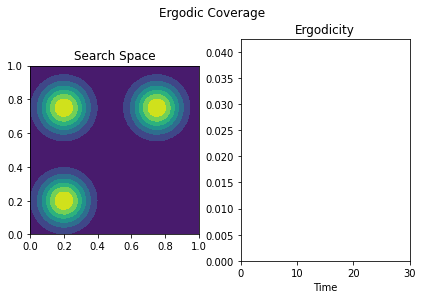

In [ ]:
animate2d_ergodic(mm_ergodic, num_iter=None, filename="mm_ergodic.mp4")
# animate2d_ergodic(mm_ergodic, num_iter=100, filename="mm_ergodic.mp4")

In [ ]:
# Spectral Decomposition
# K = 10
# Low 8 Mid 10 High 12
low = list(filter(lambda x: sum(x) < 8, np.ndindex(*[10]*2)))
high = list(filter(lambda x: sum(x) >= 8, np.ndindex(*[10]*2)))
print(len(low))
print(len(high))
f = mm_ergodic.functions
def create_band(band_k):
    return lambda x: sum([f[k]['mu_k']*f[k]['fourier_k'](torch.tensor(x)).numpy() for k in band_k])
low_band = create_band(low)
high_band = create_band(high)
recon_band = lambda x: low_band(x) + high_band(x)


fig, axes = plt.subplots(1, 4, figsize=(12+3, 3))
titles = ['Normal', 'Low', 'High', 'Reconstructed']
maps = [p1, low_band, high_band, recon_band]

fig.suptitle('Search Space')
fig.tight_layout()
levels = list(np.array(range(-4, 12))/2)
for i in range(len(axes)): 
    ax = axes[i]
    ax.set_title(titles[i])
    ax.set_aspect('equal')
    space = 1e-2
    ax.set_xlim(0-space, 1+space)
    ax.set_ylim(0-space, 1+space)
   
    X,Y = np.meshgrid(*[np.linspace(0,1)]*2)
    _s = np.stack([X.ravel(), Y.ravel()]).T

    
    q = ax.contourf(X, Y, np.array(list(map(maps[i], _s))).reshape(X.shape), levels=levels)  
    if levels is None:
        levels = q.levels
        print(levels)

plt.subplots_adjust(right=0.875)
cbar_ax = fig.add_axes([0.9, 0.05, 0.01, 0.8])
plt.colorbar(q, cax=cbar_ax)
plt.show()

36
64


NameError: name 'mm_ergodic' is not defined